In [226]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling2D, AveragePooling2D, BatchNormalization, TimeDistributed, Permute, ReLU, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

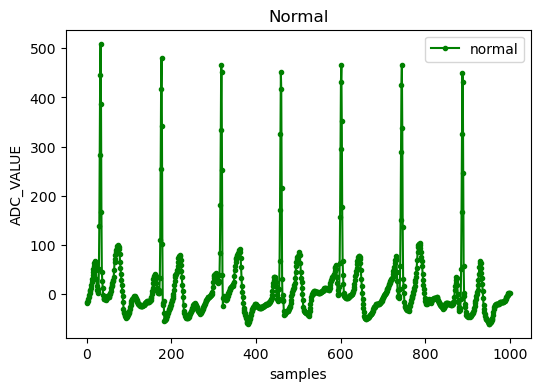

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load normal ECG data
normal_filename = r"D:\Varsity\Thesis\ECG dataset\Physionet\normal.csv"
normal_df = pd.read_csv(normal_filename, skiprows=range(1, 150000), nrows=1000)

# Plot abnormal ECG data
index = range(1, len(normal_df['Time']) + 1)
plt.plot(index, normal_df['ECG1'], 'g.', label='normal', linestyle='solid')
plt.title("Normal")
plt.xlabel("samples")
plt.ylabel("ADC_VALUE")
plt.legend()
plt.show()


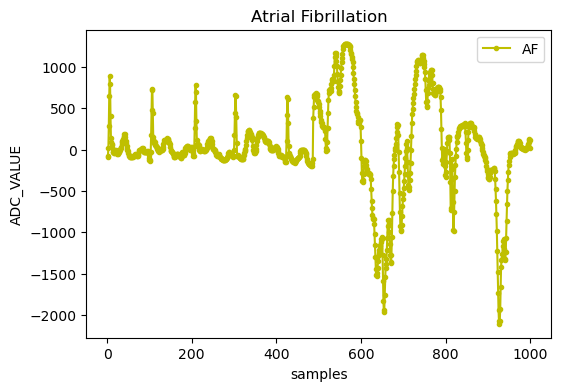

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load normal ECG data
AF_filename = r"D:\Varsity\Thesis\ECG dataset\Physionet\AF.csv"
AF_df = pd.read_csv(AF_filename, skiprows=range(1, 150000), nrows=1000)

# Plot abnormal ECG data
index = range(1, len(AF_df['Time']) + 1)
plt.plot(index, AF_df['ECG1'], 'y.', label='AF', linestyle='solid')
plt.title("Atrial Fibrillation")
plt.xlabel("samples")
plt.ylabel("ADC_VALUE")
plt.legend()
plt.show()

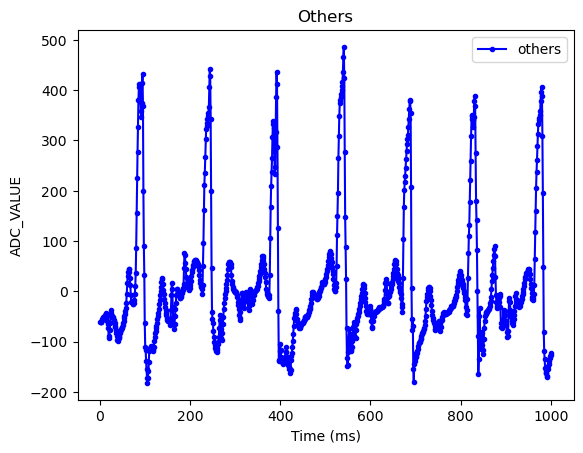

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load normal ECG data
others_filename = r"D:\Varsity\Thesis\ECG dataset\Physionet\others.csv"
others_df = pd.read_csv(others_filename, skiprows=range(1, 150000), nrows=1000)

# Plot abnormal ECG data
index = range(1, len(others_df['Time']) + 1)
plt.plot(index, others_df['ECG1'], 'b.', label='others', linestyle='solid')
plt.title("Others")
plt.xlabel("sample")
plt.ylabel("ADC_VALUE")
plt.legend()
plt.show()

In [231]:
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
CLASS = [
    "normal",
    "AF",
    "others"

]

SAMPLES_PER_PERSON = 10000

NUM_CLASSES = len(CLASS)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for ecg_index in range(NUM_CLASSES):
  ecg = CLASS[ecg_index]
  print(f"Processing index {ecg_index} for ECG : '{ecg}'.")
  
  output = ONE_HOT_ENCODED_CLASSES[ecg_index]
   
  # Construct the file path for the current ECG class
  file_path = f"D:/Varsity/Thesis/ECG dataset/Physionet/{ecg}.csv"  #D:\Varsity\Thesis\ECG dataset\Physionet
  
  df = pd.read_csv(file_path)
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_PERSON)
  print(df.shape[0])
  print(f"\tThere are {num_recordings} recordings of the {ecg} ECG.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_PERSON):
      index = i * SAMPLES_PER_PERSON + j
      # normalize the input data, between 0 to 1:

      tensor += [
          df['ECG1'][index],
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)
print(inputs.shape)
print(outputs.shape)
#print(inputs)
#print(outputs)

print("Data set parsing and preparation complete.")

Processing index 0 for ECG : 'normal'.
24314471
	There are 2431 recordings of the normal ECG.
Processing index 1 for ECG : 'AF'.
3553964
	There are 355 recordings of the AF ECG.
Processing index 2 for ECG : 'others'.
12670762
	There are 1267 recordings of the others ECG.
(4053, 10000)
(4053, 3)
Data set parsing and preparation complete.


In [232]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087

num_inputs = len(inputs)
print(num_inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]


# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print(inputs_train.shape)
print(inputs_test.shape)

print("Data set randomization and splitting complete.")

4053
(2431, 10000)
(810, 10000)
Data set randomization and splitting complete.


In [233]:
print(inputs.shape)
print(inputs.shape)

(4053, 10000)
(4053, 10000)


In [234]:
window_size = 20

'''
print(inputs_train.shape)
print(inputs_test.shape)
print(inputs_validate.shape)
'''

inputs_train = inputs_train.reshape(-1, window_size, 500)  # Assuming there are 4987 samples
inputs_test = inputs_test.reshape(-1, window_size, 500)    # Assuming there are 1662 samples
inputs_validate = np.reshape(inputs_validate, (-1, window_size, 500))

print(inputs_train.shape)
print(outputs_train.shape)
print(inputs_validate.shape)
print(outputs_validate.shape)
print(inputs_test.shape)
print(outputs_test.shape)

#print(inputs_train)

(2431, 20, 500)
(2431, 3)
(812, 20, 500)
(812, 3)
(810, 20, 500)
(810, 3)


In [235]:
print(inputs_train.shape)
print(inputs_test.shape)
print(inputs.shape)


(2431, 20, 500)
(810, 20, 500)
(4053, 10000)


In [236]:
learning_rate = 1e-4
#epochs = 50
batch_size = 128


In [237]:
# Flatten the 2D features to 1D
num_features = inputs_train.shape[-1]
num_samples = inputs_train.shape[0]
inputs_train = inputs_train.reshape(-1, num_features)
outputs_train = outputs_train.repeat(20, axis=0)  # Repeat the labels for each array


# Similarly preprocess validation and test data
inputs_validate = inputs_validate.reshape(-1, num_features)
outputs_validate = outputs_validate.repeat(20, axis=0)
inputs_test = inputs_test.reshape(-1, num_features)
outputs_test = outputs_test.repeat(20, axis=0)

print(inputs_train.shape)
print(outputs_train.shape)
print(inputs_validate.shape)
print(outputs_validate.shape)
print(inputs_test.shape)
print(outputs_test.shape)


inputs_train = inputs_train.reshape((48620, 500, 1))
inputs_validate = inputs_validate.reshape((16240, 500, 1))
inputs_test = inputs_test.reshape((16200, 500, 1))
print(inputs_train.shape)
print(outputs_train.shape)
print(inputs_validate.shape)
print(outputs_validate.shape)
print(inputs_test.shape)
print(outputs_test.shape)

(48620, 500)
(48620, 3)
(16240, 500)
(16240, 3)
(16200, 500)
(16200, 3)
(48620, 500, 1)
(48620, 3)
(16240, 500, 1)
(16240, 3)
(16200, 500, 1)
(16200, 3)


In [238]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    BatchNormalization,
    ReLU,
    GlobalAveragePooling1D,
    Dense,
    Reshape,
    Add,
)
from tensorflow.keras.models import Model

def grouped_resnet_block(x, filters, num_blocks):
    for _ in range(num_blocks):
        shortcut = x
        
        # First convolution layer in the block
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        
        # Second convolution layer in the block
        x = Conv1D(filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        
        # Adjust shortcut connection to match the shape
        if shortcut.shape[-1] != filters:
            shortcut = Conv1D(filters, kernel_size=1, padding='same')(shortcut)
        
        x = Add()([x, shortcut])
        x = ReLU()(x)
    return x

def convolution_attention_layer(x):
    # Convolutional Attention Layer
    x = Conv1D(filters=1, kernel_size=3, padding='same')(x)
    x = Reshape((-1,))(x)
    x = Dense(1, activation='softmax')(x)
    return x

def create_resnet_model(input_shape, num_classes):
    input_layer = Input(shape=(500, 1)) 
    x = BatchNormalization()(input_layer)
    x = Conv1D(16, kernel_size=3, padding='same')(x)
    x = ReLU()(x)
    
    filters = [16, 32, 64, 128]
    num_blocks = [2, 3, 4, 2]
    
    for i in range(len(filters)):
        x = grouped_resnet_block(x, filters[i], num_blocks[i])
    
    # Apply Convolutional Attention
    convolution_att = convolution_attention_layer(x)
    
    x = Dense(64, activation='relu')(convolution_att)
   
    x = Dropout(0.3)(x)  # Add dropout with a 20% dropout rate
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Define input shape and number of classes based on your dataset
input_shape = (500, 1)  # Replace with your actual input shape
num_classes = 3  # Replace with the number of classes in your dataset

# Create the ResNet model
model = create_resnet_model(input_shape, num_classes)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_35 (InputLayer)       [(None, 500, 1)]             0         []                            
                                                                                                  
 batch_normalization_335 (B  (None, 500, 1)               4         ['input_35[0][0]']            
 atchNormalization)                                                                               
                                                                                                  
 conv1d_372 (Conv1D)         (None, 500, 16)              64        ['batch_normalization_335[0][0
                                                                    ]']                           
                                                                                           

In [240]:
optim = tf.optimizers.Adam(learning_rate = learning_rate)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=10, min_lr=1e-6, verbose=1)

checkpoint_filepath = os.path.join(r"D:\Varsity\Thesis\ECG dataset\Physionet", 'resnet_model.h5')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)
    


In [241]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(inputs_train, outputs_train, validation_data =(inputs_validate, outputs_validate),
          epochs = 10, batch_size = 2000, shuffle=True, callbacks=[reduce_lr, model_checkpoint])

Epoch 1/10


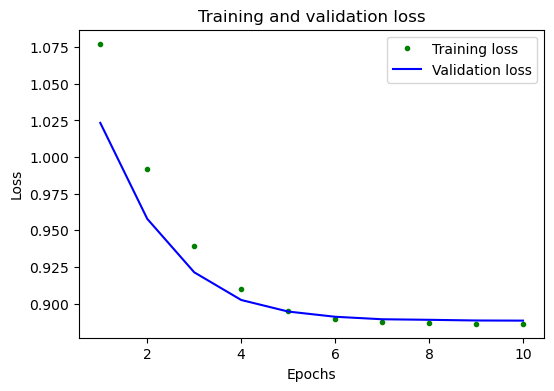

[6.0, 4.0]


In [200]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [201]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)
#y_true = outputs_test
#y_pred = predictions


26/26 [==============================] - 1s 24ms/step
predictions =
 [[0.605 0.092 0.303]
 [0.605 0.092 0.303]
 [0.605 0.092 0.303]
 ...
 [0.605 0.092 0.303]
 [0.605 0.092 0.303]
 [0.605 0.092 0.303]]
actual =
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [174]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Calculate the confusion matrix
#cm = confusion_matrix(actual_labels, predicted_labels)


# Calculate percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


In [175]:
class_names = ["Normal", "AF", "Others"]


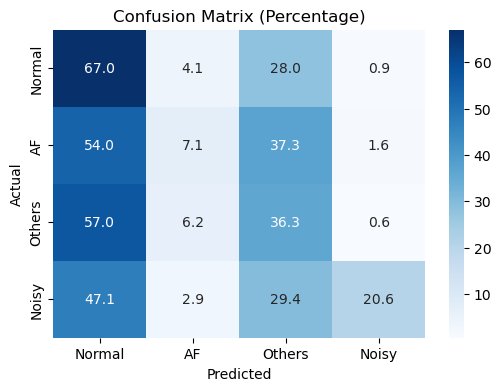

In [176]:
# Create a heatmap to visualize the confusion matrix in percentage scale
plt.figure(figsize=(6, 4))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Percentage)')
plt.show()



In [140]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(actual_labels, predicted_labels, average=None)
recall = recall_score(actual_labels, predicted_labels, average=None)
f1 = f1_score(actual_labels, predicted_labels, average=None)

# Calculate the confusion matrix
#conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
#print("Confusion Matrix:\n", conf_matrix)

NameError: name 'actual_labels' is not defined